In [1]:
%pip install google-cloud-storage
%pip install google-cloud-bigquery pandas
%pip install ipython-autotime
%pip install gensim
%pip install pyldavis
%pip install matplotlib
%pip install wordcloud
%pip install bertopic
%pip install sentence-transformers
%pip install umap-learn
%pip install hdbscan
%load_ext autotime


time: 649 µs (started: 2024-07-21 16:27:55 +00:00)


In [2]:
# link this notebook to my google drive so I can retrieve data files from there
# Import the dedicated library
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.67 s (started: 2024-07-21 16:27:55 +00:00)


In [3]:
 #Authenticating with google cloud
 from google.colab import auth
 auth.authenticate_user()

time: 777 ms (started: 2024-07-21 16:27:57 +00:00)


In [4]:
from google.cloud import bigquery
import pandas as pd

time: 1.5 s (started: 2024-07-21 16:27:58 +00:00)


In [5]:
# Creating a sample dataframe
project_id = 'nlp-project-427710'
dataset_id = 'covid'
table_id = 'uns_prep_covid1'

# initializing the client
client = bigquery.Client(project=project_id)

time: 14.2 ms (started: 2024-07-21 16:28:00 +00:00)


In [6]:
# Querying the table into a dataframe

# i need the full table id
table_ref = f'{project_id}.{dataset_id}.{table_id}'

query = f'SELECT * FROM {table_ref}'
query_job = client.query(query)

# convert res to df
df = query_job.to_dataframe()

# inspect

print(df.shape)

(699961, 10)
time: 15 s (started: 2024-07-21 16:28:00 +00:00)


In [7]:
%time
df.head()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


status_id                                       text  \
0  1244670357342224385    Live😭😭#Covid_19 https://t.co/O40EulfHoP   
1  1244531006054391809                             fuck #Covid_19   
2  1246595661274812416      Mood #covid19 https://t.co/3rXTDkgHBL   
3  1245511108275965953      Fuck #Covid19 https://t.co/QxQ0RrCs4i   
4  1245752597300027398  This😂😂😂😂 #Covid19 https://t.co/0z1OW0oMQD   

   upper_words  tweet_length  no_sentences  has_username  has_hashtag  \
0          0.0          12.0           0.0         False         True   
1          0.0          12.0           0.0         False         True   
2          0.0          12.0           0.0         False         True   
3          0.0          12.0           0.0         False         True   
4          0.0          12.0           0.0         False         True   

   ELIPSIS_instances light_clean_text  clean_text  
0                0.0      livecovid_    livecovid  
1                0.0      fuck covid_  fuck covid  
2                0.0      mood covid   mood covid  
3                0.0      fuck covid   fuck covid  
4                0.0      this covid   this covid

time: 35.8 ms (started: 2024-07-21 16:28:15 +00:00)


In [8]:
from transformers import pipeline
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

time: 18.6 s (started: 2024-07-21 16:28:15 +00:00)


In [9]:

import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

df['tokenized_text'] = df['clean_text'].apply(lambda x: simple_preprocess(x, deacc=True))

# Displaying the first few rows --check
print(df[['clean_text', 'tokenized_text']].head())

   clean_text tokenized_text
0   livecovid    [livecovid]
1  fuck covid  [fuck, covid]
2  mood covid  [mood, covid]
3  fuck covid  [fuck, covid]
4  this covid  [this, covid]
time: 1min 15s (started: 2024-07-21 16:28:34 +00:00)


First trial Simplified LDA--ALSO CREATING THE SETS USED IN THE TOTALITY OF THE code


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

def detokenize(tokens):
    return ' '.join(tokens)

#sampled_tokenized_text = df['tokenized_text']
#sampled_cleaned_text = df['clean_text']

sampled_tokenized_text = df['tokenized_text'].sample(n=1000, random_state=1)
sampled_cleaned_text = df['clean_text'].sample(n=1000, random_state=1)

#here we remove STOP WORDS!!!!! (FOrgotten)==> assign back to original
sampled_tokenized_text = sampled_tokenized_text.apply(remove_stop_words)
sampled_cleaned_text=sampled_tokenized_text.apply(detokenize)

#dictionary = Dictionary(df['tokenized_text'])
dictionary=Dictionary(sampled_tokenized_text)

print(f"Number of terms in dictionary: {len(dictionary)}")
# Filtering out extremes to limit the number of features
#dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)<======THis will be included!!!When we use the whole set
##### !!!! DONT FORGET TO REMOVE!!!!!!!

#Coprus creatiion
#corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]
corpus = [dictionary.doc2bow(text) for text in sampled_tokenized_text]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Printing each topic with its top 10 words
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)
#sampled_cleaned_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of terms in dictionary: 4309
(0, '0.046*"covid" + 0.039*"coronavirus" + 0.012*"amp" + 0.007*"pandemic" + 0.005*"day" + 0.005*"world" + 0.005*"hope" + 0.005*"great" + 0.005*"get" + 0.004*"say"')
(1, '0.025*"coronavirus" + 0.020*"covid" + 0.008*"get" + 0.007*"say" + 0.007*"like" + 0.006*"country" + 0.005*"day" + 0.005*"go" + 0.005*"need" + 0.004*"amp"')
(2, '0.049*"covid" + 0.018*"coronavirus" + 0.016*"amp" + 0.014*"work" + 0.007*"keep" + 0.006*"people" + 0.005*"home" + 0.005*"like" + 0.004*"stay" + 0.004*"pandemic"')
(3, '0.030*"coronavirus" + 0.018*"covid" + 0.013*"people" + 0.009*"amp" + 0.009*"case" + 0.007*"need" + 0.007*"death" + 0.005*"take" + 0.005*"virus" + 0.004*"could"')
(4, '0.053*"covid" + 0.025*"coronavirus" + 0.007*"case" + 0.006*"time" + 0.006*"spread" + 0.006*"people" + 0.006*"day" + 0.006*"get" + 0.005*"use" + 0.005*"help"')
(5, '0.036*"coronavirus" + 0.036*"covid" + 0.010*"lockdown" + 0.006*"get" + 0.006*"pandemic" + 0.006*"via" + 0.005*"day" + 0.005*"time" + 0.

In [11]:
#Since in our first try we created a simple example with 10 topics here we visualize what the topic signifyis and means
# IN this example we see that we have 10 topics from which at least 4 are verey closely related between them
#specifically topic 2, 8, 10 ,7

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


time: 6.35 s (started: 2024-07-21 16:29:55 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


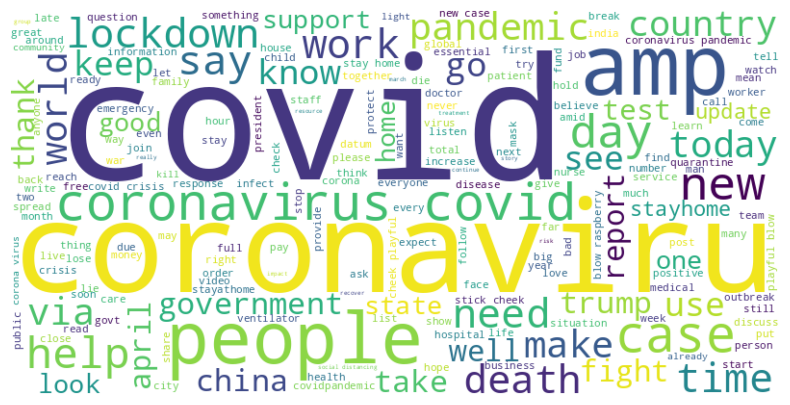

time: 1.32 s (started: 2024-07-21 16:30:01 +00:00)


In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#!!!!!!!! FIX IT FOR ALL SET!!!!!!!!!
#all_words = ' '.join([' '.join(text) for text in df['tokenized_text']])
all_words = ' '.join([' '.join(text) for text in sampled_tokenized_text])


#WorldCLoud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Creating a pretty visualiztion for the most common Terms as they appear within the dataset


What the NG Plot Represents

**Nodes:**

Represent unique tokens (words) from your tokenized text.
Edges: Represent co-occurrences of these tokens within the same text. An edge between two nodes means that the corresponding tokens appeared together in at least one document.
Edge Weights: Indicate how often the tokens co-occur. Higher weights suggest more frequent co-occurrence.

 **Clusters of Nodes:**

Groups of closely connected nodes can indicate terms that frequently appear together and may represent related concepts or topics.
Network Density: A dense network with many edges suggests a high level of co-occurrence among tokens, while a sparse network indicates less frequent co-occurrence.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


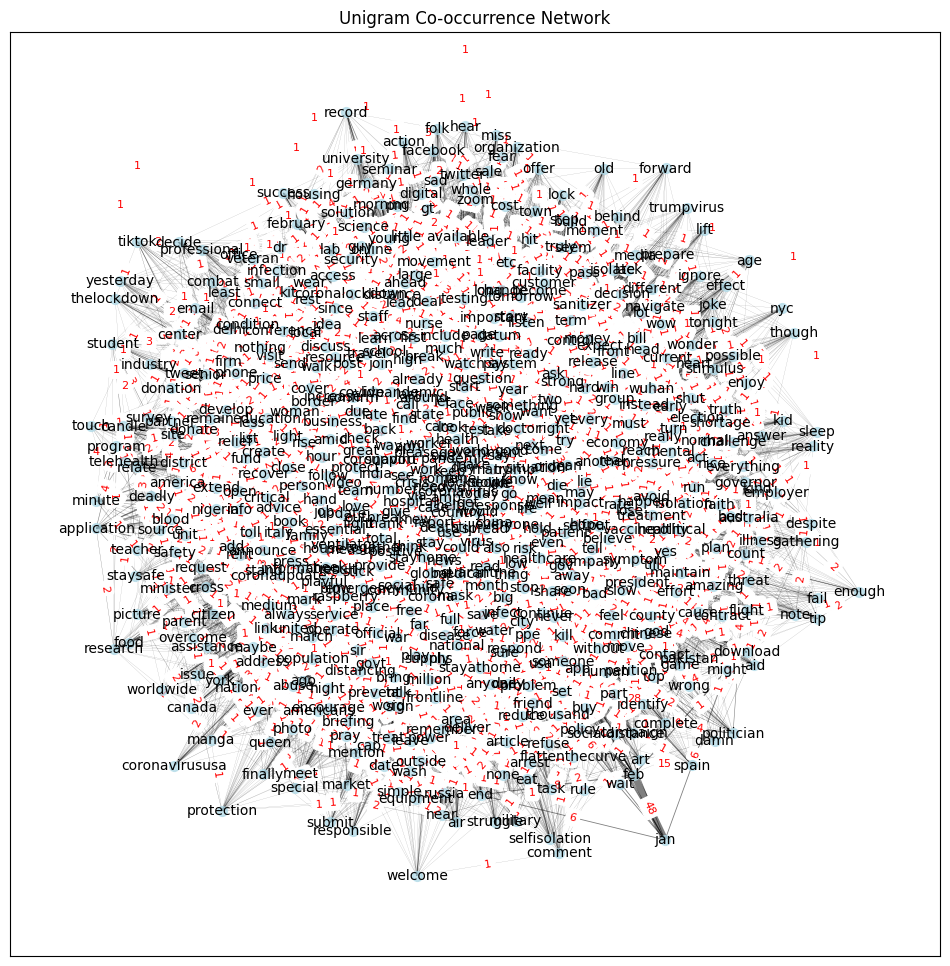

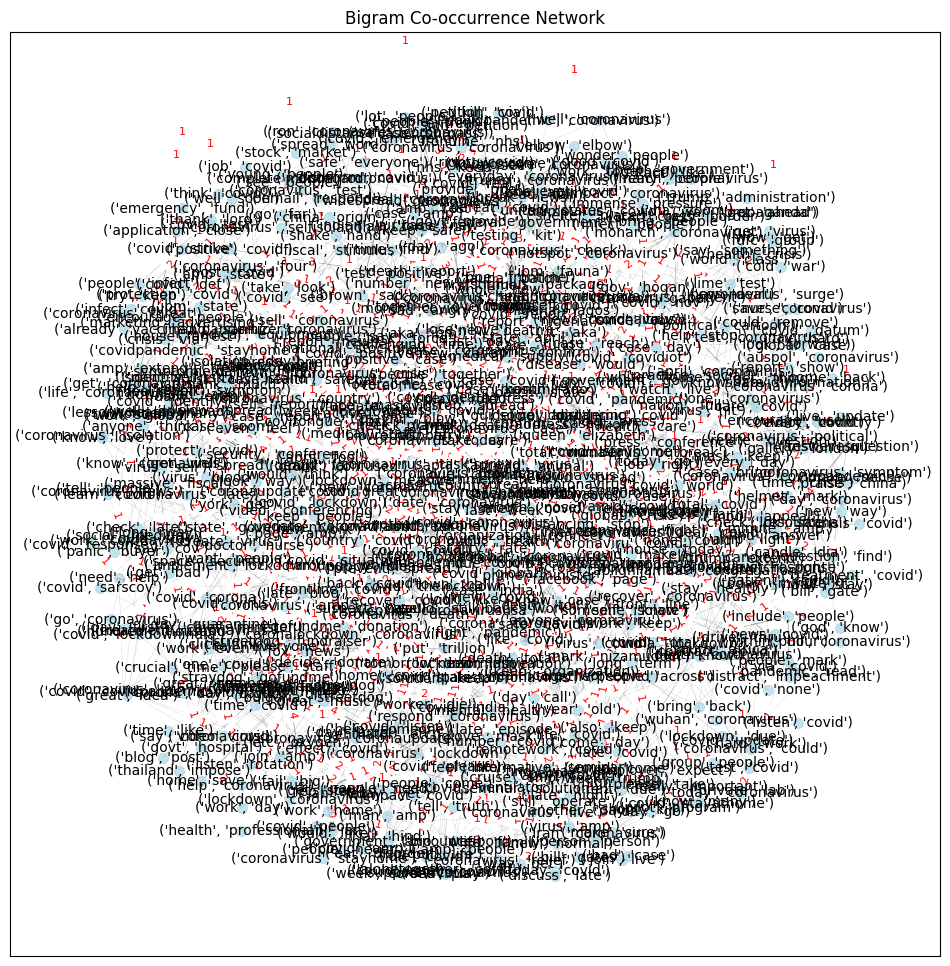

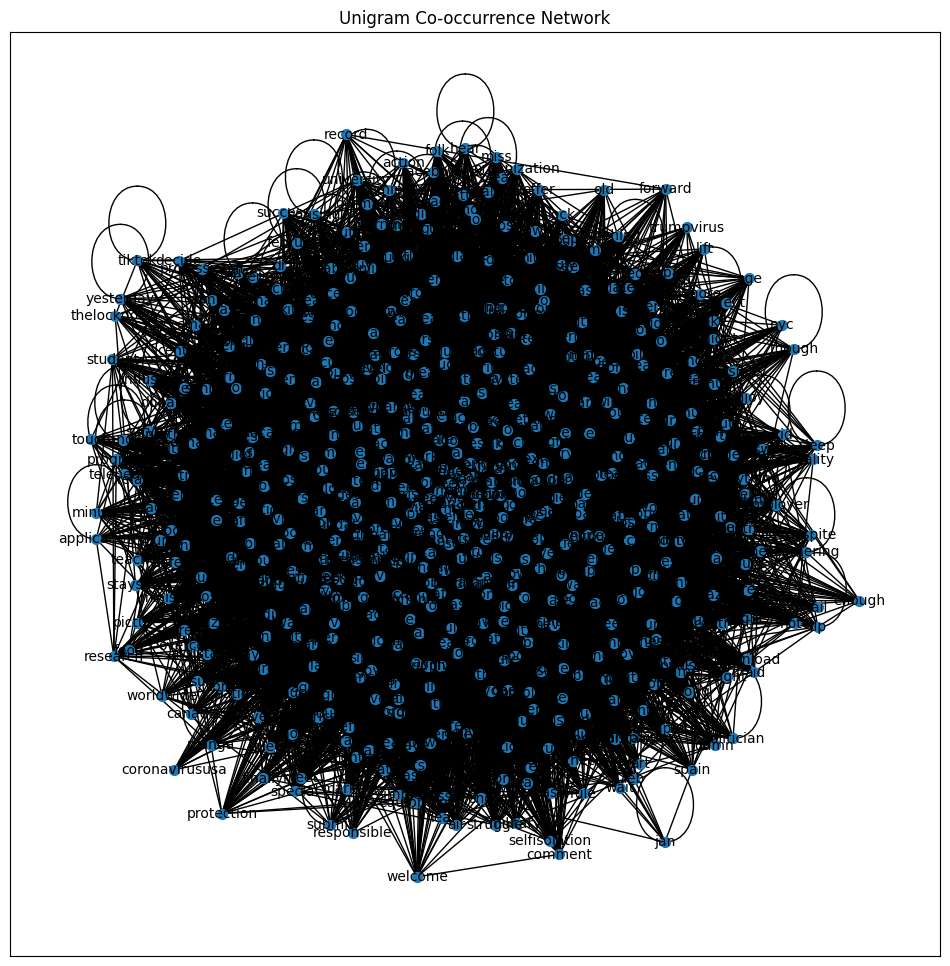

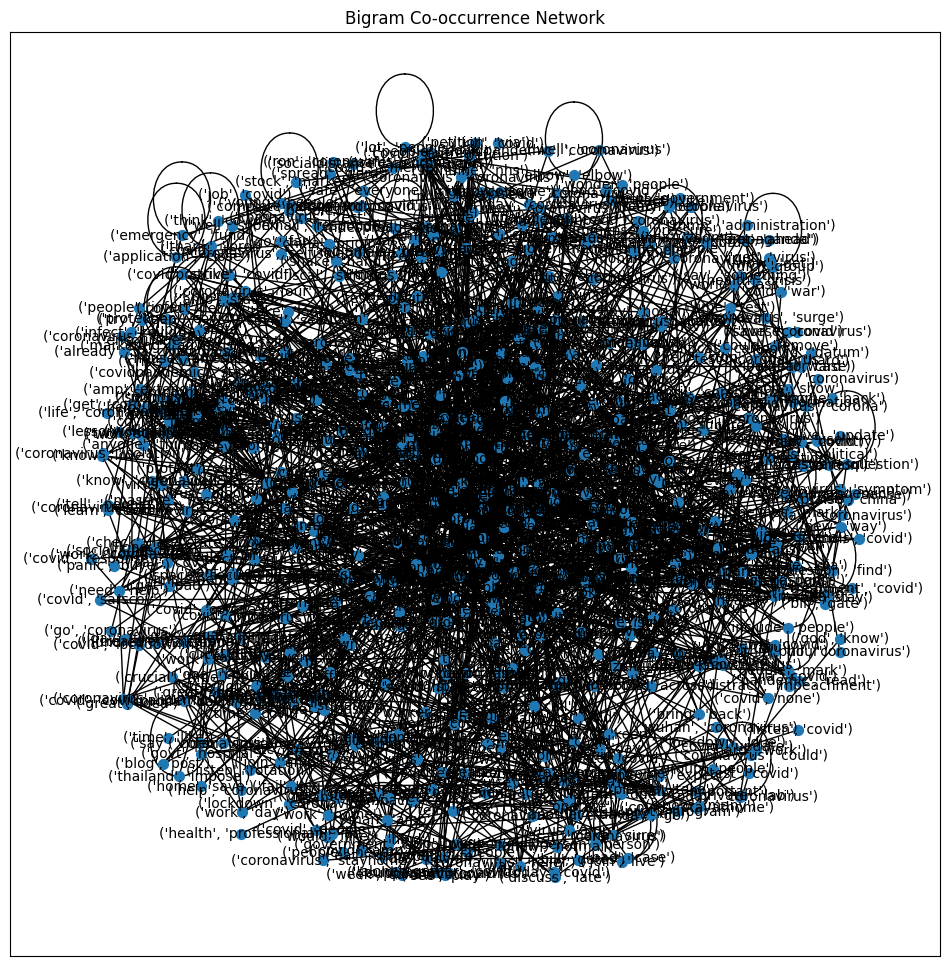

time: 3min 33s (started: 2024-07-21 16:30:02 +00:00)


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from nltk import bigrams as nltk_bigrams, trigrams as nltk_trigrams
import nltk
nltk.download('punkt')

all_unigrams = [token for text in sampled_tokenized_text for token in text]
all_bigrams = [bigram for text in sampled_tokenized_text for bigram in nltk_bigrams(text)]
# Counting frequencies
unigram_freq = Counter(all_unigrams)
bigram_freq = Counter(all_bigrams)

# Filtering by frequency the most frequent uni-grasms and bi-grams as they appear in our documners
common_unigrams = {term for term, freq in unigram_freq.items() if freq >= 5}
common_bigrams = {bigram for bigram, freq in bigram_freq.items() if freq >= 2}

def create_network(token_lists, common_tokens, n_gram=False):
    co_occurrence = nx.Graph()

    for text in token_lists:
        if n_gram:
            n_grams = list(nltk_bigrams(text)) if n_gram == 'bigram' else list(nltk_trigrams(text))
            for i in range(len(n_grams)):
                for j in range(i + 1, len(n_grams)):
                    n_gram_i = n_grams[i]
                    n_gram_j = n_grams[j]
                    if n_gram_i in common_tokens and n_gram_j in common_tokens:
                        if co_occurrence.has_edge(n_gram_i, n_gram_j):
                            co_occurrence[n_gram_i][n_gram_j]['weight'] += 1
                        else:
                            co_occurrence.add_edge(n_gram_i, n_gram_j, weight=1)
        else:
            for i in range(len(text)):
                for j in range(i + 1, len(text)):
                    term_i = text[i]
                    term_j = text[j]
                    if term_i in common_tokens and term_j in common_tokens:
                        if co_occurrence.has_edge(term_i, term_j):
                            co_occurrence[term_i][term_j]['weight'] += 1
                        else:
                            co_occurrence.add_edge(term_i, term_j, weight=1)
    return co_occurrence

# Create uni and bi-gran networks
unigram_network = create_network(sampled_tokenized_text, common_unigrams)
bigram_network = create_network(sampled_tokenized_text, common_bigrams, n_gram='bigram')

# Plotting function with weights
def plot_network(network, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(network, k=0.5, seed=42)
    nx.draw_networkx_nodes(network, pos, node_size=50, node_color='lightblue', alpha=0.7)
    edges = network.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    nx.draw_networkx_edges(network, pos, edgelist=edges, width=[weight * 0.1 for weight in weights], alpha=0.5)
    edge_labels = {(u, v): d['weight'] for u, v, d in network.edges(data=True)}
    nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels, font_size=8, font_color='red')
    nx.draw_networkx_labels(network, pos, font_size=10)
    plt.title(title)
    plt.show()

# Plotting function NO weights
def plot_network_no_Weight(network, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(network, k=0.5, seed=42)
    nx.draw_networkx_nodes(network, pos, node_size=50)
    nx.draw_networkx_edges(network, pos, width=1)
    nx.draw_networkx_labels(network, pos, font_size=10)
    plt.title(title)
    plt.show()

# Plotting networks WITH Weights (number of co-occurance)
plot_network(unigram_network, 'Unigram Co-occurrence Network')
plot_network(bigram_network, 'Bigram Co-occurrence Network')

# Plotting networks  WITHOUT weights
plot_network_no_Weight(unigram_network, 'Unigram Co-occurrence Network')
plot_network_no_Weight(bigram_network, 'Bigram Co-occurrence Network')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0:
covid corona virus update great
Topic #1:
case death new total report
Topic #2:
coronavirus pandemic lockdown know day
Topic #3:
stay home save life lockdown
Topic #4:
amp people work help like


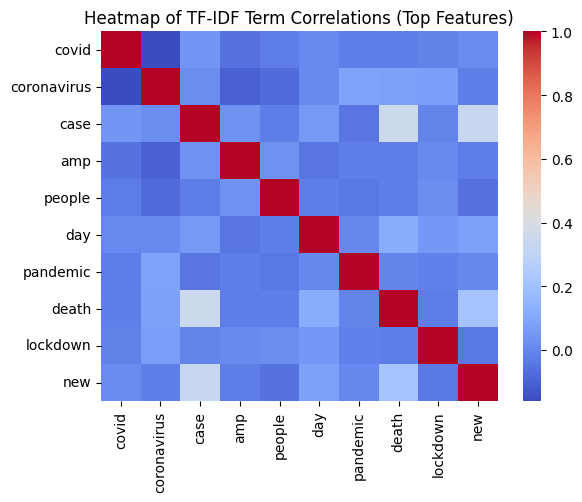

time: 977 ms (started: 2024-07-21 16:33:36 +00:00)


In [14]:
#Short Explanation
#NMF (Non-Negative Matrix Factorization): A technique used to extract topics from a document-term matrix. It factorizes the TF-IDF matrix into two non-negative matrices, representing topics and word distributions.
# n_components=10: This specify the number of topics to extract. In our case, it will find 10 topics.
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

# Text vectorizer (implementing TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english')

_joined = [' '.join(tokens) for tokens in sampled_tokenized_text]

X= vectorizer.fit_transform(_joined)
#X = vectorizer.fit_transform(df['clean_text'])

# Fit the NMF model
nmf_model = NMF(n_components=5, random_state=1)
nmf_model.fit(X)

# Displaying the topics
# vectorizer.get_feature_names_out(): Retrieves the feature names (words) from the TF-IDF
# vectorizer.topic.argsort()[:-11:-1]: (could be changed remember to fix comment)Sorts the words in descending order of importance for each topic and selects the top 10 words.
# Prints the top 10 words for each topic, showing what words are most significant for each of the extracted topics.
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-6:-1]]))

tfidf_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Suming the tfidf scores for each feature across ALL documents
feature_importance = tfidf_matrix.sum(axis=0)

# Selecting the top 10 most important features
top_features = feature_importance.nlargest(10).index

# Reduce the TF-IDF matrix to only the top N features
reduced_tfidf_matrix = tfidf_matrix[top_features]

#a heatmap of term correlations to visualize relationships between terms.plt.figure(figsize=(12, 8))
sns.heatmap(reduced_tfidf_matrix.corr(), cmap='coolwarm', annot=False, fmt='.1f')
plt.title('Heatmap of TF-IDF Term Correlations (Top Features)')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


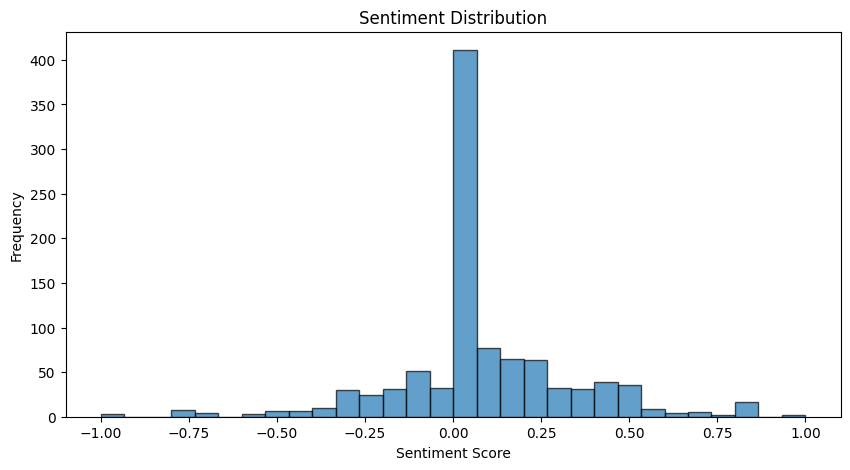

time: 665 ms (started: 2024-07-21 16:33:37 +00:00)


In [15]:
#TextBlob: A library used for processing textual data and performing sentiment analysis.
from textblob import TextBlob

dfSenti= pd.DataFrame()
#Function to get the sentiment of the text, where the score ranges from -1 (very negative) to +1 (very positive).
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

sentiments = [get_sentiment(text) for text in _joined]

# Add sentiment scores to the DataFrame
dfSenti['sentiment'] = sentiments

# Plot sentiment distribution
plt.figure(figsize=(10, 5))
plt.hist(dfSenti['sentiment'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


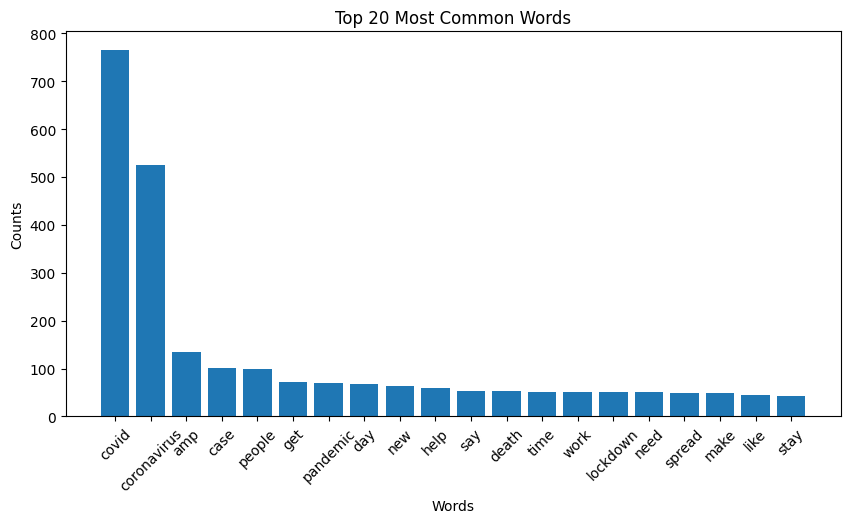

time: 344 ms (started: 2024-07-21 16:33:38 +00:00)


In [16]:
#Calculating most common UNI-grams (words)
from collections import Counter

# We Flatten the list of tokenized words
#all_words = [word for text in df['tokenized_text'] for word in text]
all_words = [word for text in sampled_tokenized_text for word in text]
# Get the frequency distribution
word_freq = Counter(all_words)

# Get the most common words
common_words = word_freq.most_common(20)


# Plotting the top --20-- unigrams
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


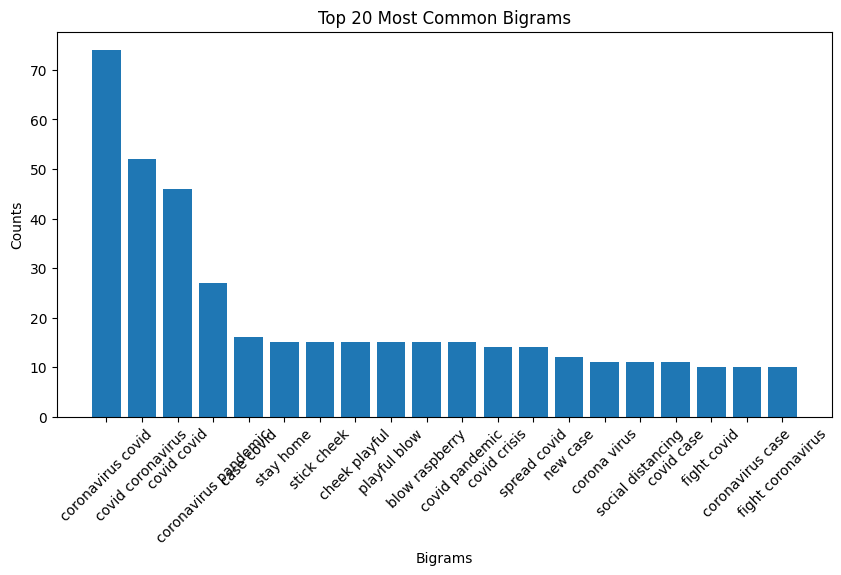

time: 381 ms (started: 2024-07-21 16:33:38 +00:00)


In [17]:
#Calculating most common bi-grams
from nltk.util import ngrams
from collections import Counter

# Creating bigrams
#bigrams = [bigram for text in df['tokenized_text'] for bigram in ngrams(text, 2)]
bigrams = [bigram for text in sampled_tokenized_text for bigram in ngrams(text, 2)]
bigram_freq = Counter(bigrams)

# Plotting the top --20-- bigrams
bigrams, counts = zip(*bigram_freq.most_common(20))
bigrams = [" ".join(bigram) for bigram in bigrams]

plt.figure(figsize=(10, 5))
plt.bar(bigrams, counts)
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


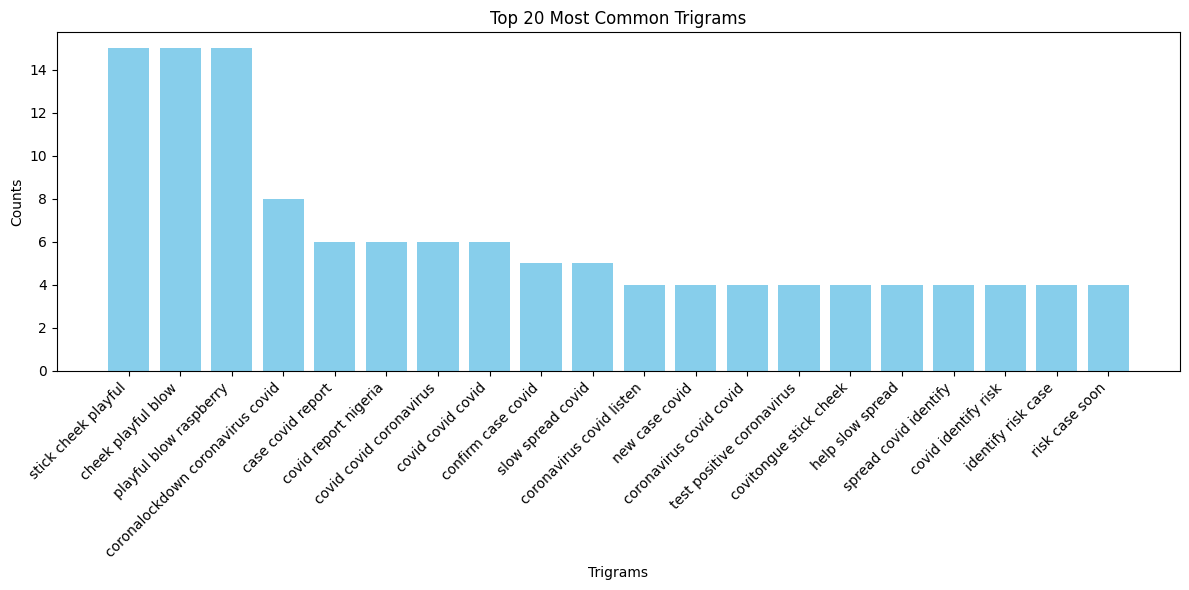

time: 434 ms (started: 2024-07-21 16:33:39 +00:00)


In [18]:
#Calculating most common trigrams
from nltk.util import ngrams
from collections import Counter


# Creating trigrams
trigrams = [trigram for text in sampled_tokenized_text for trigram in ngrams(text, 3)]

# Count frequencies of trigrams
trigram_freq = Counter(trigrams)

# Get the top 20 most common trigrams
top_trigrams = trigram_freq.most_common(20)

# Separate trigrams and their counts
trigrams, counts = zip(*top_trigrams)
trigrams = [" ".join(trigram) for trigram in trigrams]

# Plotting the top 20 trigrams
plt.figure(figsize=(12, 6))
plt.bar(trigrams, counts, color='skyblue')
plt.title('Top 20 Most Common Trigrams')
plt.xlabel('Trigrams')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#NO TRigrmas appear more than once -- This can give us a good idea whether we need to work with trigrams or not
#We should not work with trigrams :)

In [19]:
#My-check
#sampled_tokenized_text
sampled_cleaned_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


42678     face mask effective slow spread say cov widely...
240742    two person test positive covid sri lanka total...
346474    chinese global campaign fail big time medical ...
508838    thing really serious sad visit glad stick crui...
337773    story year old man amp poor family lockdown vi...
                                ...                        
493124    logic science behind statement covid infect pe...
124421             need defeat covid carol basin marine oil
285710    mit covid challenge pretty cool many great com...
596303    miss two introvert lol coronavirus covid daugh...
347681    forget poor people spread covid widely force s...
Name: tokenized_text, Length: 1000, dtype: object

time: 8.96 ms (started: 2024-07-21 16:33:39 +00:00)


**Explanation for the below code window**

LSA is a technique which "attempts to discover the underlying relationships between **words**" the difference with LDA is that (LDA) discovers the underlying **topics** in a corpus of text.

The LSA (Latent Semantic Analysis) **matrix** represents the document-term matrix (representation of a collection of documents, where rows correspond to documents, and columns correspond to terms (words or tokens can be bi-tri grams ect)) after dimensionality reduction using Truncated Singular Value Decomposition (SVD)

LSA reduces the dimensionality of the matrix, effectively summarizing the original data into k (in our case k=3 seems the more meaningfull) topics.

**PLOT**

**Document Distribution:**
The scatter plot shows how documents are distributed in the 2D space created by LSA. Documents that are close to each other are more similar in terms of the topics they cover.

**Topic Separation:**
If topics are well-separated in the plot, it means that LSA has effectively identified distinct clusters of documents based on their content.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


LSA matrix shape: (1000, 3)
LSA matrix:
 [[ 0.58147373  0.1554003   0.79858566]
 [ 0.97016582  0.15052192 -0.19005642]
 [ 0.96988182 -0.22362188 -0.09655315]
 ...
 [ 0.92131034 -0.3717516   0.11396496]
 [ 0.87238035 -0.48793955 -0.02945361]
 [ 0.67806772 -0.08730479  0.72979589]]

Terms:
Topic 1:
covid coronavirus case coronavirus covid covid coronavirus
Topic 2:
case report death new case covid
Topic 3:
spread spread covid slow spread feel download self report


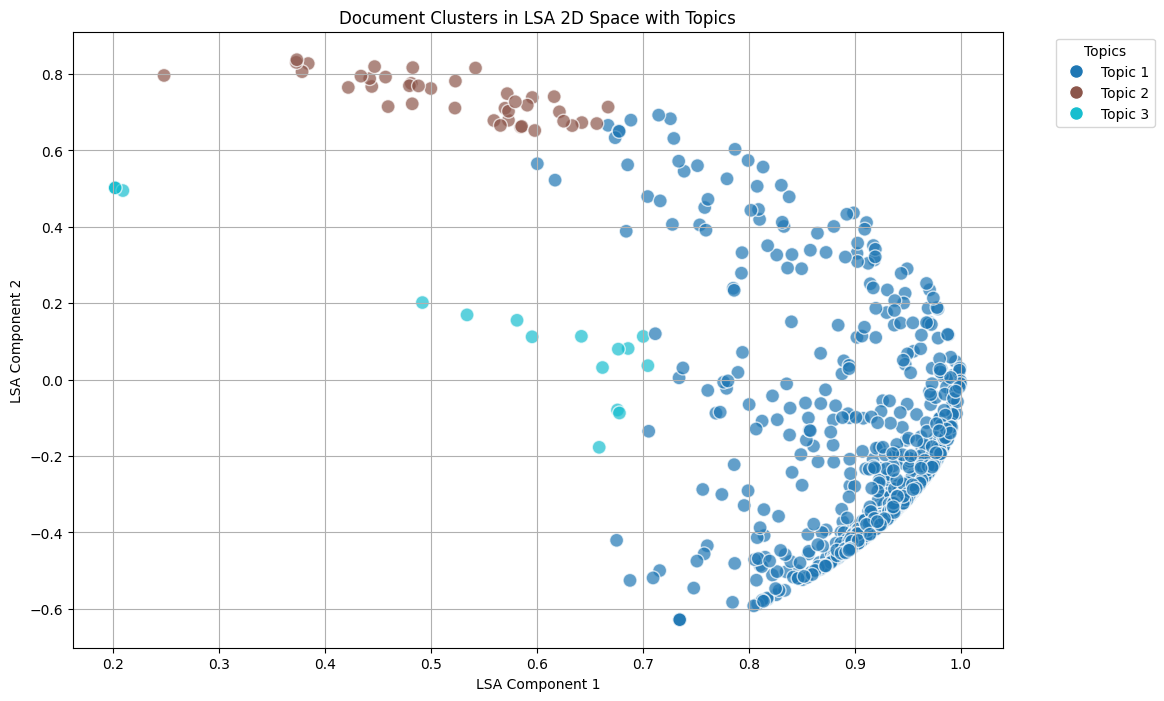

time: 13.2 s (started: 2024-07-21 16:33:39 +00:00)


In [20]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from matplotlib.lines import Line2D
# Create TF-IDF Vectorizer with n-grams
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # Use both unigrams and bigrams

# Transforming documents to TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(sampled_cleaned_text)

# Performing our LSA with TruncatedSVD
#This allows for  dimensinality reduction by redusing document-term matrix to 3 dimensions.
#Theory:?? TruncatedSVD is an implementation of SVD that performs dimensionality reduction by decomposing the document-term matrix into a set of topics.
lsa = TruncatedSVD(n_components=3)  # Reduce to 3 topics/components
normalizer = Normalizer(copy=False)
lsa_pipeline = make_pipeline(lsa, normalizer)
lsa_matrix = lsa_pipeline.fit_transform(tfidf_matrix)

# Displaying the LSA matrix
print("LSA matrix shape:", lsa_matrix.shape)
print("LSA matrix:\n", lsa_matrix)

#Here we display the MOST frequent terms associated with each topic
terms = vectorizer.get_feature_names_out()
print("\nTerms:")
for i, topic in enumerate(lsa.components_):
    print(f"Topic {i + 1}:")
    sorted_terms = [terms[i] for i in topic.argsort()[:-6:-1]]
    print(" ".join(sorted_terms))

# Scatter plot of the first two LSA components
plt.figure(figsize=(12, 8))

# Assign each document to the most influential topic
topic_assignments = np.argmax(lsa_matrix, axis=1)

scatter = plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=topic_assignments, cmap='tab10', alpha=0.7, edgecolors='w', s=100)

# Creating Legends
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10, label=f'Topic {i + 1}') for i in range(len(np.unique(topic_assignments)))]
plt.legend(handles=handles, title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Document Clusters in LSA 2D Space with Topics')
plt.xlabel('LSA Component 1')
plt.ylabel('LSA Component 2')
plt.grid(True)
plt.show()


EVALUATING MY LDA

In [21]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=sampled_tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)
print('Perplexity: ', lda.log_perplexity(corpus))

#offering a simple evaluation of our basic first model (LDA) without hyper-parameterizing it
#test to be completed for all 3 of our models in the end in order to retrieve the best resutls possible
# OUR main evaluation metric in this case is the Coherence Score (mainly because is common between our 3 models)
# While perplexity can be usefull in interpreting the results and clusters
# we do not have this metrix in BERTopic as well as in LSA but there we can calculate the diversitty (between cluster)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


\nCoherence Score:  0.2596983744343727
Perplexity:  -8.046815437003746
time: 756 ms (started: 2024-07-21 16:33:52 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


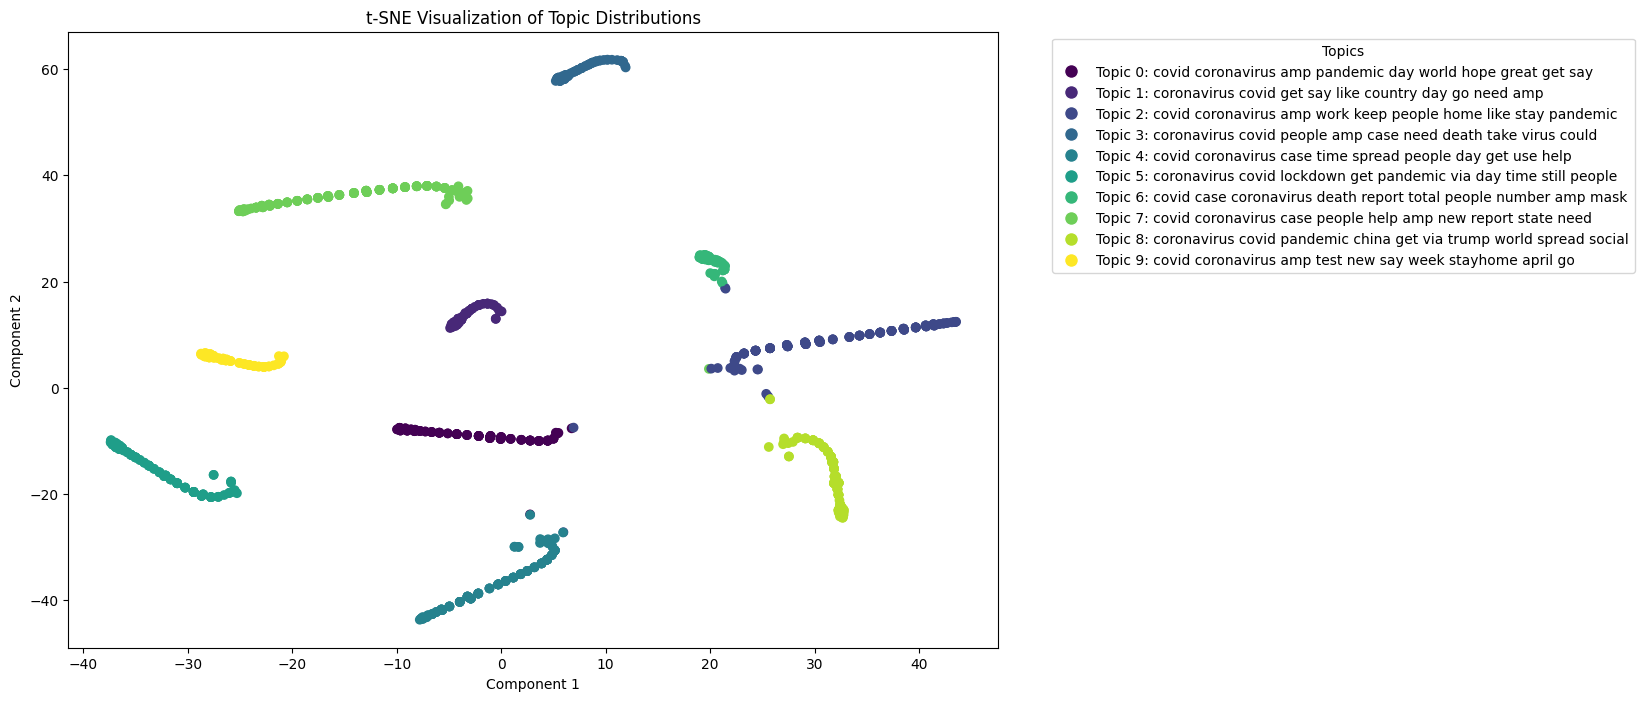

time: 13 s (started: 2024-07-21 17:22:35 +00:00)


In [38]:
from sklearn.manifold import TSNE
import numpy as np
#topic distributions
doc_topic_matrix = np.zeros((len(corpus), lda.num_topics))

for i, doc in enumerate(corpus):
    topic_probs = lda.get_document_topics(doc, minimum_probability=0)
    for topic_id, prob in topic_probs:
        doc_topic_matrix[i, topic_id] = prob

# t-SNE
tsne_model = TSNE(n_components=2, random_state=0)
topic_embeddings = tsne_model.fit_transform(doc_topic_matrix)

#  top words for each topic
topic_names = {}
for topic_id in range(lda.num_topics):
    top_words = [word for word, _ in lda.show_topic(topic_id, 10)]
    topic_names[topic_id] = ' '.join(top_words)

# main topic for each document
doc_topic_labels = np.argmax(doc_topic_matrix, axis=1)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(topic_embeddings[:, 0], topic_embeddings[:, 1], c=doc_topic_labels, cmap='viridis', marker='o')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(idx)), markersize=10, label=f'Topic {idx}: {topic_names[idx]}') for idx in range(lda.num_topics)]
plt.legend(handles=handles, title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Visualization of Topic Distributions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [23]:
#sampled_cleaned_text

time: 401 µs (started: 2024-07-21 16:34:00 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


========================================BERT STAFFFFFF===================================

THis is **a first attempt to apply BERTopic** this is a simplistic no parameterized model


In [24]:
from bertopic import BERTopic

BErTopic = BERTopic()#<== my BErTopic model

# Convert my text to a list
sampled_cleaned_text_MEH = sampled_cleaned_text.tolist()

# Check the input data
print(f"Number of documents: {len(sampled_cleaned_text_MEH)}")
print(f"Sample documents: {sampled_cleaned_text_MEH[:5]}")

topics, probabs = BErTopic.fit_transform(sampled_cleaned_text_MEH)

# Checking what we get for probabilities and topics
print(f"Topics: {topics}")
print(f"Probabilities: {probabs}")
print("Topics and their keywords:")
topic_info = BErTopic.get_topic_info()
print(topic_info)

# Display the most IMPORTANT documents FOR EACH topic
topic_to_docs = {}
for idx, topic in enumerate(topics):
    if topic not in topic_to_docs:
        topic_to_docs[topic] = []
    topic_to_docs[topic].append(sampled_cleaned_text_MEH[idx])

for topic, docs in topic_to_docs.items():
    print(f"\nTopic {topic}:")
    for doc in docs:
        print(f"- {doc}")


#Visualize some topic_info
topic_info = BErTopic.get_topic_info()
topic_info


Number of documents: 1000
Sample documents: ['face mask effective slow spread say cov widely use may help prevent people infect transmit disease unknowingly coronavirus facemask', 'two person test positive covid sri lanka total report country increase epidemiology unit srilanka lka coronavirus covid', 'chinese global campaign fail big time medical equipment deliver country turn shady make junk kg grp', 'thing really serious sad visit glad stick cruise ship sick people way get stay safe covid alaskaadventure', 'story year old man amp poor family lockdown victim covid lockdown stop bathroom maria sumo pub']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics: [8, 1, 5, -1, 6, -1, 1, -1, -1, 0, 0, -1, 10, -1, -1, 0, 3, 9, -1, -1, 6, 9, -1, 11, 1, 0, 3, -1, 8, -1, 6, 0, -1, -1, -1, -1, 8, -1, 0, -1, -1, 7, 5, -1, -1, 0, -1, -1, 2, 7, -1, 0, -1, 3, -1, 11, -1, -1, -1, -1, 0, 2, 9, 8, 4, -1, -1, 5, -1, -1, 2, 3, 10, -1, 3, 9, 9, -1, -1, 1, 2, 2, 1, 4, 0, -1, 1, 11, 4, 3, -1, 7, 2, 2, 12, 3, -1, 13, 1, -1, 11, -1, -1, -1, 0, -1, 4, -1, 1, -1, -1, 6, 10, 0, -1, -1, -1, -1, 1, 5, -1, -1, -1, 2, -1, 2, 1, -1, 3, 13, -1, 1, -1, 13, 5, 8, 12, -1, 6, 7, 6, 5, -1, -1, -1, -1, -1, 4, 2, -1, -1, -1, 2, -1, -1, 5, -1, 1, -1, -1, -1, 4, -1, -1, -1, 10, -1, -1, 10, 5, 1, 7, 2, 8, -1, 8, 4, -1, -1, -1, -1, 3, -1, -1, -1, -1, 2, 5, -1, 13, 2, 8, -1, -1, 0, 6, -1, -1, -1, 0, 5, -1, -1, -1, 5, 6, 2, 0, -1, 0, 3, 10, 14, 3, 2, 13, 1, -1, -1, 0, 4, -1, -1, 3, -1, -1, -1, 8, -1, -1, 2, 5, 3, -1, -1, 0, 10, -1, 2, 6, 1, 2, 12, 1, 6, -1, -1, -1, -1, 6, 4, -1, 4, 0, 2, -1, 7, 3, 3, 7, 11, 14, 1, 9, 3, -1, 2, -1, -1, 1, 12, -1, 1, -1, 4, 6, -1, -1, -1, 0, 9, -

Topic  Count                                Name  \
0      -1    467     -1_covid_coronavirus_people_get   
1       0     88      0_coronavirus_covid_corona_cat   
2       1     81           1_case_death_total_report   
3       2     71      2_trump_feb_coronavirus_people   
4       3     44       3_work_covid_nurse_telehealth   
5       4     42               4_amp_work_covid_keep   
6       5     32   5_china_chinese_coronavirus_wuhan   
7       6     30           6_lockdown_day_covid_lift   
8       7     29             7_covid_take_anyone_one   
9       8     26      8_mask_ventilator_face_patient   
10      9     19    9_coronalockdown_listen_via_song   
11     10     16             10_hand_wash_elbow_nose   
12     11     15        11_stay_home_save_california   
13     12     15  12_quarantine_game_gamespot_infect   
14     13     15  13_fund_donate_ontario_application   
15     14     10      14_slow_download_self_identify   

                                       Representation  \
0   [covid, coronavirus, people, get, pandemic, am...   
1   [coronavirus, covid, corona, cat, datum, lie, ...   
2   [case, death, total, report, new, covid, india...   
3   [trump, feb, coronavirus, people, jan, covid, ...   
4   [work, covid, nurse, telehealth, care, program...   
5   [amp, work, covid, keep, job, together, educat...   
6   [china, chinese, coronavirus, wuhan, praise, t...   
7   [lockdown, day, covid, lift, thelockdown, exte...   
8   [covid, take, anyone, one, well, right, though...   
9   [mask, ventilator, face, patient, covid, buy, ...   
10  [coronalockdown, listen, via, song, music, enj...   
11  [hand, wash, elbow, nose, mouth, drone, wife, ...   
12  [stay, home, save, california, colorado, safe,...   
13  [quarantine, game, gamespot, infect, gamersvsc...   
14  [fund, donate, ontario, application, care, fig...   
15  [slow, download, self, identify, app, feel, sy...   

                                  Representative_Docs  
0   [rise global pandemic corona virus covid gymte...  
1   [coronaviru government practice reach coronavi...  
2   [russia add new covid case bring total number ...  
3   [well election thief bill barr hang around wor...  
4   [via gt want find way give back covid crisis s...  
5   [yoga studio amp amazing world class instructo...  
6   [communist party china lie try cover lead coro...  
7   [tell coronavirus incubation period day lockdo...  
8   [take control life covid jesus please take whe...  
9   [coronavirus mask ccpvirus would buy mask chin...  
10  [coronalockdown coronavirus covid great music ...  
11  [keep wash hand protect covid covid health hea...  
12  [save life stay home many save find mycoronaim...  
13  [mrs butler birthday today idea get board game...  
14  [emergency fund update application close gift ...  
15  [help slow spread covid identify risk case soo...

time: 36.1 s (started: 2024-07-21 16:34:00 +00:00)


=========================== LDA again For Hyper PARAMETERS =================================:

FIne Tinnung the LDA and gathering the results
This is a first step to find the best unsuppervised model based on the metrics that will result


**Explanation of Use of Hyperparameters**

**alpha_values**  this signifies how topics are divided/spread between documents. "Symmetric" means each topic has the same chance, while "asymmetric" means some topics are more likely (for a document). Numeric values (like 0.01 or 0.1) adjust how many topics each document has, with lower values meaning fewer topics and higher values meaning more.

**eta_values** this signifies how words are spread across topics. "Symmetric" means every word is equally likely in any topic, "auto" sets it automatically, and numeric values (like 0.01 or 0.1) decide how many words are in each topic. Lower values mean fewer words per topic, while higher values mean more.

**num_topics**  this par signifies how many topics the model will find, such as 5 or 10.

**iterations_values** this signifies how many times the model goes through the data. More iterations (like 50 or 100) make the model more accurate but take longer.

**gamma_threshold_values** this signifies when the model should stop iterating. Lower values (like 0.001 or 0.01) mean the model will keep iterating longer to reach stricter accuracy.

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

id2word = Dictionary(sampled_tokenized_text)

corpus = [id2word.doc2bow(text) for text in sampled_tokenized_text]

# Defining a set of possible hyperparameters for which we will loop through
#No more than the below are used due to the time that this takes for the whole dataset
alphas = ['symmetric', 'asymmetric', 0.01, 0.1, 0.5, 1]
etas = ['symmetric', 'auto', 0.01, 0.1, 0.5, 1]
topics = [5, 10]  # Number of topics
iterations = [50, 100]  # Number of iterations
gamma_thresholds = [0.001, 0.01]  # Gamma threshold values

# Array to store dict of results and metrics
results = []

for topic in topics:
    for alpha in alphas:
        for eta in etas:
            for iteration in iterations:
                for gamma_threshold in gamma_thresholds:
                    # Build LDA model
                    lda_model = gensim.models.LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        num_topics=topic,  # topics
                        random_state=100,
                        update_every=1,
                        chunksize=100,
                        passes=10,
                        alpha=alpha,
                        eta=eta,
                        iterations=iteration,  # iterations
                        eval_every=1,  # Evaluate the model's  perplexity on EVERY iter
                        minimum_probability=0.01,  #  probability threshold
                        gamma_threshold=gamma_threshold  # gamma parameter
                    )

                    # find the coherence for each case (each hyperparameter set)
                    coherence_model_lda = CoherenceModel(model=lda_model, texts=sampled_tokenized_text, dictionary=id2word, coherence='c_v')
                    coherence_lda = coherence_model_lda.get_coherence()

                    # find the perplexity for each case (each hyperparameter set)
                    perplexity_lda = lda_model.log_perplexity(corpus)


                    # Code to prepare and calculate silhouette-score and Davies-Bouldin index
                    doc_topic_matrix = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])
                    doc_topic_matrix = np.array([[prob for _, prob in doc] for doc in doc_topic_matrix])

                    # find topic assignments for each document
                    lda_topic_assignments = np.argmax(doc_topic_matrix, axis=1)

                    # effort to calculate the silhouette-score
                    if len(np.unique(lda_topic_assignments)) > 1:  # check if we have more that 1 clusters formed
                        silhouette_avg = silhouette_score(doc_topic_matrix, lda_topic_assignments)
                    else:
                        silhouette_avg = float('nan')

                    # effort to calculate the Davies-Bouldin index
                    if len(np.unique(lda_topic_assignments)) > 1:  # check if we habve more that 1 cluster(s) formed
                        davies_bouldin_avg = davies_bouldin_score(doc_topic_matrix, lda_topic_assignments)
                    else:
                        davies_bouldin_avg = float('nan')

                    # Store results
                    results.append({
                        'num_topics': topic,
                        'alpha': alpha,
                        'eta': eta,
                        'iterations': iteration,
                        'gamma_threshold': gamma_threshold,
                        'coherence': coherence_lda,
                        'perplexity': perplexity_lda,
                        'silhouette_score': silhouette_avg,
                        'davies_bouldin_index': davies_bouldin_avg,
                        'lda_model':lda_model
                    })

# Create DataFrame
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     num_topics      alpha        eta  iterations  gamma_threshold  coherence  \
0             5  symmetric  symmetric          50            0.001   0.315423   
1             5  symmetric  symmetric          50            0.010   0.297247   
2             5  symmetric  symmetric         100            0.001   0.305643   
3             5  symmetric  symmetric         100            0.010   0.308160   
4             5  symmetric       auto          50            0.001   0.315423   
..          ...        ...        ...         ...              ...        ...   
283          10          1        0.5         100            0.010   0.417602   
284          10          1          1          50            0.001   0.644640   
285          10          1          1          50            0.010   0.641850   
286          10          1          1         100            0.001   0.644640   
287          10          1          1         100            0.010   0.641850   

     perplexity  silhouette

In [26]:
results_sorted = results_df.sort_values(by=['coherence', 'perplexity'], ascending=[False, True])

# sorted results
print("Results sorted by Coherence and Perlpexity:")
results_sorted.head(10)

Results sorted by Coherence and Perlpexity:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics       alpha eta  iterations  gamma_threshold  coherence  \
284          10           1   1          50            0.001   0.644640   
286          10           1   1         100            0.001   0.644640   
285          10           1   1          50            0.010   0.641850   
287          10           1   1         100            0.010   0.641850   
45            5  asymmetric   1          50            0.010   0.502020   
94            5         0.1   1         100            0.001   0.491193   
44            5  asymmetric   1          50            0.001   0.482654   
95            5         0.1   1         100            0.010   0.470084   
46            5  asymmetric   1         100            0.001   0.468894   
71            5        0.01   1         100            0.010   0.467947   

     perplexity  silhouette_score  davies_bouldin_index  \
284   -8.316868          0.336871              0.584514   
286   -8.316868          0.336871              0.584514   
285   -8.316962          0.396844              0.619592   
287   -8.316962          0.396844              0.619592   
45    -7.839570          0.763992              0.317717   
94    -7.849722          0.781890              0.310819   
44    -7.839712          0.765512              0.325026   
95    -7.847911          0.803867              0.298600   
46    -7.839851          0.790618              0.295123   
71    -7.816204          0.841657              0.313110   

                                             lda_model  
284  LdaModel<num_terms=4309, num_topics=10, decay=...  
286  LdaModel<num_terms=4309, num_topics=10, decay=...  
285  LdaModel<num_terms=4309, num_topics=10, decay=...  
287  LdaModel<num_terms=4309, num_topics=10, decay=...  
45   LdaModel<num_terms=4309, num_topics=5, decay=0...  
94   LdaModel<num_terms=4309, num_topics=5, decay=0...  
44   LdaModel<num_terms=4309, num_topics=5, decay=0...  
95   LdaModel<num_terms=4309, num_topics=5, decay=0...  
46   LdaModel<num_terms=4309, num_topics=5, decay=0...  
71   LdaModel<num_terms=4309, num_topics=5, decay=0...

time: 95.2 ms (started: 2024-07-21 17:07:19 +00:00)


Below we Visualize the above top 5 (based on coherence) models

They are exported in html because i could visualize all 5 in a cell in jupyter

Results are explained in omre details in the report

In [27]:
top_results=results_sorted.head(5)

vis_data_list = []
for indx, row in top_results.iterrows():
    lda_model = row['lda_model']
    vis_data = gensimvis.prepare(lda_model, corpus, id2word)
    #pyLDAvis.display(vis_data)
    html_file = f'lda_visualization_{indx}.html'
    pyLDAvis.save_html(vis_data, html_file)
    print(f"Visualization saved as {html_file}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Visualization saved as lda_visualization_284.html
Visualization saved as lda_visualization_286.html
Visualization saved as lda_visualization_285.html
Visualization saved as lda_visualization_287.html
Visualization saved as lda_visualization_45.html
time: 8.17 s (started: 2024-07-21 17:07:19 +00:00)


In [28]:
import pandas as pd
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


# def detokenize(characters):
#     return ' '.join(characters.split())

# Converting each list of tokens to a sentence <==to be removed /commented out
# rejoined_texts = sampled_cleaned_text.apply(detokenize)
# print(rejoined_texts)
#print(sampled_cleaned_text)

#Similarly to LDA we store results here
results_BERT = []

def calculate_topic_diversity(topic_model):
    topics = topic_model.get_topics()
    # Extracting words from ALL topics
    all_words = []
    for topic in topics:
        if len(topics[topic]) > 0:  # if there is an empty topic we filter out
            all_words.extend([word for word, _ in topics[topic]])
    # Calculating any unique words
    unique_words = set(all_words)

    # Compute diversity score
    diversity_score = len(unique_words) / len(all_words)

    return diversity_score

def calculate_coherence_score(topic_model, mydoc):
    # Get the topics from BERTopic
    topics = topic_model.get_topics()

    # Filter out empty topics and get the topic words
    topic_words = [[word for word, _ in topics[topic]] for topic in topics if len(topics[topic]) > 0]

    cleaned_docs = topic_model._preprocess_text(mydoc)

    vectorizer = topic_model.vectorizer_model
    tokenizer = vectorizer.build_tokenizer()

    tokens = [tokenizer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()

    return coherence


#Set of hyperparameters to be used===> Due to time restrictions no more cases are examined
#Results show significan difference regarding the coherence related mainly with top_n_words parameter
hyperparameters = {
    'nr_topics': [10, 15, 20],
    'min_topic_size': [10, 20],
    'top_n_words': [2, 5, 10, 12],
}


for nr_topics in hyperparameters['nr_topics']:
    for min_topic_size in hyperparameters['min_topic_size']:
        for top_n_words in hyperparameters['top_n_words']:
            topic_model = BERTopic(nr_topics=nr_topics, min_topic_size=min_topic_size, top_n_words=top_n_words)

            topic_model.fit(sampled_cleaned_text)

            coherence_score = calculate_coherence_score(topic_model, sampled_cleaned_text)
            diversity_score = calculate_topic_diversity(topic_model)


            results_BERT.append({
                'nr_topics': nr_topics,
                'min_topic_size': min_topic_size,
                'top_n_words': top_n_words,
                'coherence': coherence_score,
                'diversity':diversity_score,
            })

results_df_BERT = pd.DataFrame(results_BERT)
results_df_BERT.sort_values(by='coherence', ascending=False)
results_df_BERT.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nr_topics  min_topic_size  top_n_words  coherence  diversity
0         10              10            2   0.809144   0.800000
1         10              10            5   0.558012   0.820000
2         10              10           10   0.345788   0.830000
3         10              10           12   0.307076   0.816667
4         10              20            2   0.715138   0.625000
5         10              20            5   0.496943   0.711111
6         10              20           10   0.373509   0.750000
7         10              20           12   0.350960   0.738095
8         15              10            2   0.748102   0.900000
9         15              10            5   0.491648   0.813333

time: 9min 20s (started: 2024-07-21 17:07:27 +00:00)


In [29]:
print(results_df_BERT.index)

RangeIndex(start=0, stop=24, step=1)
time: 1.58 ms (started: 2024-07-21 17:16:48 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


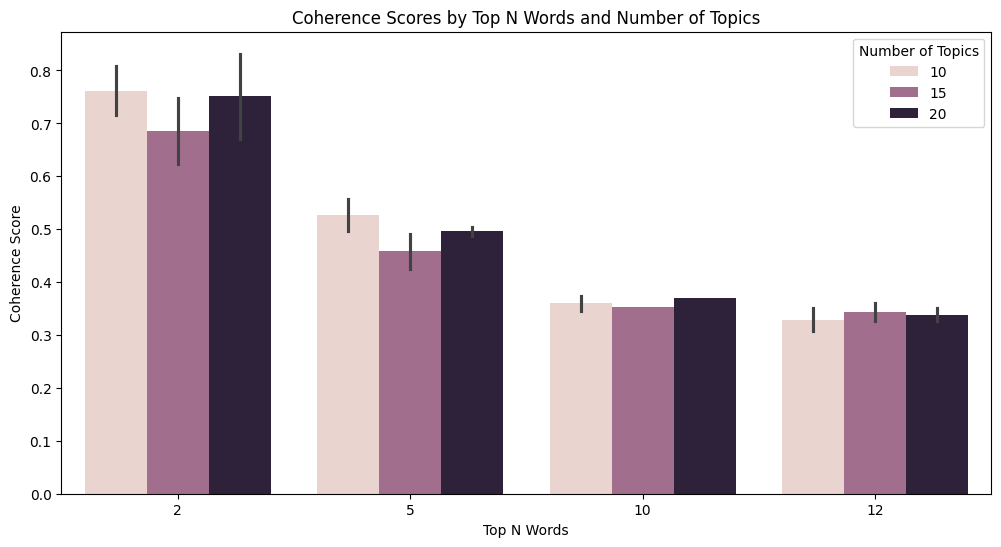

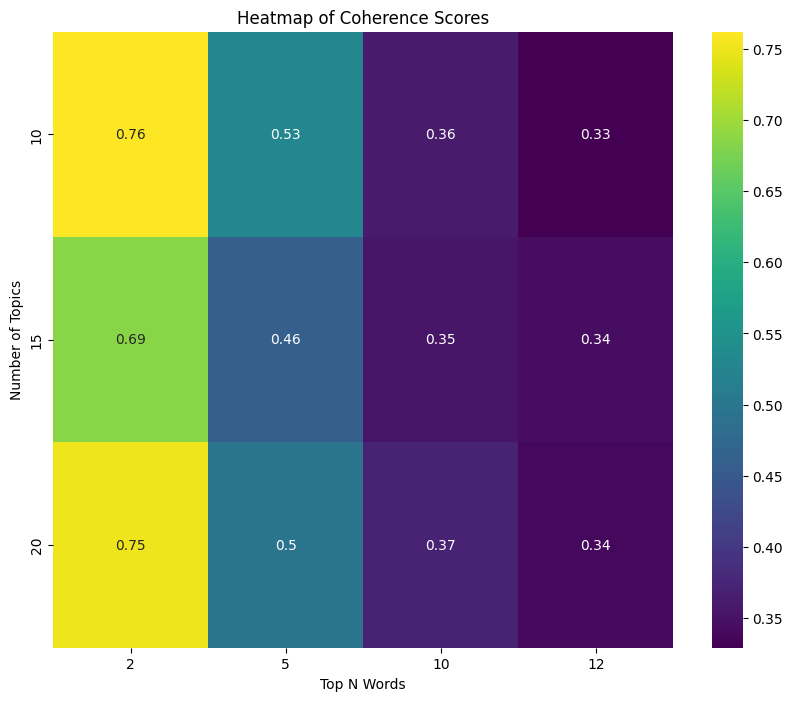

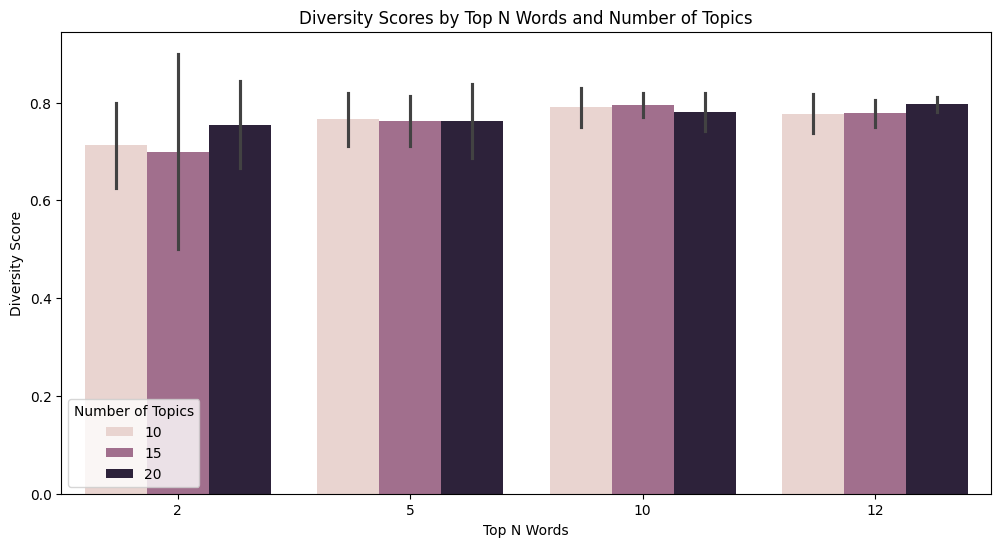

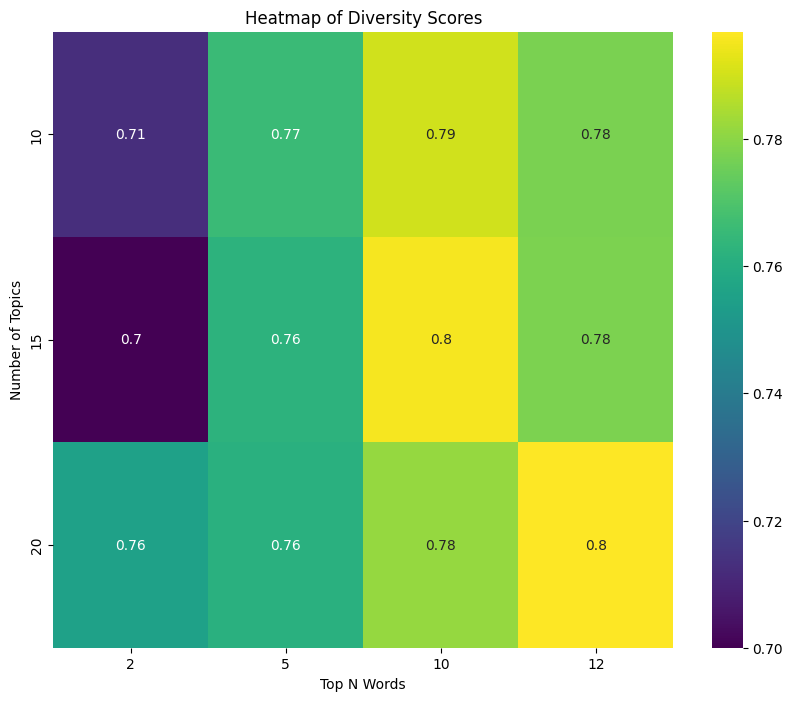

time: 2.08 s (started: 2024-07-21 17:16:48 +00:00)


In [30]:
#Visualizations , suggested mainly from google colab

# Visualization for coherence scores
plt.figure(figsize=(12, 6))
sns.barplot(x='top_n_words', y='coherence', hue='nr_topics', data=results_df_BERT)
plt.title('Coherence Scores by Top N Words and Number of Topics')
plt.xlabel('Top N Words')
plt.ylabel('Coherence Score')
plt.legend(title='Number of Topics')
plt.show()

# Heatmap for coherence scores
results_pivot_coherence = results_df_BERT.pivot_table(values='coherence', index='nr_topics', columns='top_n_words', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(results_pivot_coherence, annot=True, cmap='viridis')
plt.title('Heatmap of Coherence Scores')
plt.xlabel('Top N Words')
plt.ylabel('Number of Topics')
plt.show()

# Visualization for diversity scores
plt.figure(figsize=(12, 6))
sns.barplot(x='top_n_words', y='diversity', hue='nr_topics', data=results_df_BERT)
plt.title('Diversity Scores by Top N Words and Number of Topics')
plt.xlabel('Top N Words')
plt.ylabel('Diversity Score')
plt.legend(title='Number of Topics')
plt.show()

# Heatmap for diversity scores
results_pivot_diversity = results_df_BERT.pivot_table(values='diversity', index='nr_topics', columns='top_n_words', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(results_pivot_diversity, annot=True, cmap='viridis')
plt.title('Heatmap of Diversity Scores')
plt.xlabel('Top N Words')
plt.ylabel('Number of Topics')
plt.show()



In [31]:
sorted_df_LADS = results_df.sort_values(by='coherence', ascending=False)
sorted_df_BERT = results_df_BERT.sort_values(by='coherence', ascending=False)

# Get the top 10 rows
top_ten_df_LADS = sorted_df_LADS.head(10)
top_ten_df_BERT = sorted_df_BERT.head(10)

final_results_BERT_LAD = pd.concat([top_ten_df_LADS, top_ten_df_BERT], ignore_index=True, sort=False)
final_results_BERT_LAD

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics       alpha  eta  iterations  gamma_threshold  coherence  \
0         10.0           1    1       100.0            0.001   0.644640   
1         10.0           1    1        50.0            0.001   0.644640   
2         10.0           1    1       100.0            0.010   0.641850   
3         10.0           1    1        50.0            0.010   0.641850   
4          5.0  asymmetric    1        50.0            0.010   0.502020   
5          5.0         0.1    1       100.0            0.001   0.491193   
6          5.0  asymmetric    1        50.0            0.001   0.482654   
7          5.0         0.1    1       100.0            0.010   0.470084   
8          5.0  asymmetric    1       100.0            0.001   0.468894   
9          5.0        0.01    1       100.0            0.010   0.467947   
10         NaN         NaN  NaN         NaN              NaN   0.831701   
11         NaN         NaN  NaN         NaN              NaN   0.809144   
12         NaN         NaN  NaN         NaN              NaN   0.748102   
13         NaN         NaN  NaN         NaN              NaN   0.715138   
14         NaN         NaN  NaN         NaN              NaN   0.670566   
15         NaN         NaN  NaN         NaN              NaN   0.622518   
16         NaN         NaN  NaN         NaN              NaN   0.558012   
17         NaN         NaN  NaN         NaN              NaN   0.504461   
18         NaN         NaN  NaN         NaN              NaN   0.496943   
19         NaN         NaN  NaN         NaN              NaN   0.491648   

    perplexity  silhouette_score  davies_bouldin_index  \
0    -8.316868          0.336871              0.584514   
1    -8.316868          0.336871              0.584514   
2    -8.316962          0.396844              0.619592   
3    -8.316962          0.396844              0.619592   
4    -7.839570          0.763992              0.317717   
5    -7.849722          0.781890              0.310819   
6    -7.839712          0.765512              0.325026   
7    -7.847911          0.803867              0.298600   
8    -7.839851          0.790618              0.295123   
9    -7.816204          0.841657              0.313110   
10         NaN               NaN                   NaN   
11         NaN               NaN                   NaN   
12         NaN               NaN                   NaN   
13         NaN               NaN                   NaN   
14         NaN               NaN                   NaN   
15         NaN               NaN                   NaN   
16         NaN               NaN                   NaN   
17         NaN               NaN                   NaN   
18         NaN               NaN                   NaN   
19         NaN               NaN                   NaN   

                                            lda_model  nr_topics  \
0   LdaModel<num_terms=4309, num_topics=10, decay=...        NaN   
1   LdaModel<num_terms=4309, num_topics=10, decay=...        NaN   
2   LdaModel<num_terms=4309, num_topics=10, decay=...        NaN   
3   LdaModel<num_terms=4309, num_topics=10, decay=...        NaN   
4   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
5   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
6   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
7   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
8   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
9   LdaModel<num_terms=4309, num_topics=5, decay=0...        NaN   
10                                                NaN       20.0   
11                                                NaN       10.0   
12                                                NaN       15.0   
13                                                NaN       10.0   
14                                                NaN       20.0   
15                                                NaN       15.0   
16                                                NaN

time: 64.3 ms (started: 2024-07-21 17:16:50 +00:00)


============================= LSA STAFFFFF========================


In [32]:
from sklearn.feature_extraction.text import CountVectorizer


results_LSA = []

def calculate_coherence_score_lsa(lsa_model, vectorizer, docs):
    X = vectorizer.transform(docs)
    topic_matrix = lsa_model.transform(X)

    # creating the topic words
    terms = vectorizer.get_feature_names_out()
    topics = np.argsort(lsa_model.components_, axis=1)[:, ::-1]
    topic_words = [[terms[i] for i in topic] for topic in topics]
    cleaned_docs = [doc.split() for doc in docs]

    # dictionary and corpus cretion for coherence calculation
    dictionary = corpora.Dictionary(cleaned_docs)
    corpus = [dictionary.doc2bow(doc) for doc in cleaned_docs]

    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=cleaned_docs,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()

    return coherence

hyperparameters_lsa = {
    'n_components': [10, 15, 20],
    'top_n_words': [2, 5, 10, 12],
}


for n_components in hyperparameters_lsa['n_components']:
    for top_n_words in hyperparameters_lsa['top_n_words']:
        # creating and fitting the countVectorizer
        vectorizer = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split())
        X = vectorizer.fit_transform(sampled_cleaned_text)

        # creating and fitting  the LSA model
        svd = TruncatedSVD(n_components=n_components)
        normalizer = Normalizer()
        lsa_model = svd.fit_transform(X)
        lsa_model = normalizer.fit_transform(lsa_model)


        coherence_score = calculate_coherence_score_lsa(svd, vectorizer, sampled_cleaned_text)

        # effort to calculate diversity ( by using tokenized terms from vectorizer)
        tokens = [doc.split() for doc in sampled_cleaned_text]
        all_words = [word for doc in tokens for word in doc]
        unique_words = set(all_words)
        diversity_score = len(unique_words) / len(all_words)


        results_LSA.append({
            'n_components': n_components,
            'top_n_words': top_n_words,
            'coherence': coherence_score,
            'diversity': diversity_score
        })

results_df_LSA = pd.DataFrame(results_LSA)
results_df_LSA.sort_values(by='coherence', ascending=False)
results_df_LSA.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components  top_n_words  coherence  diversity
0            10            2   0.343070   0.301814
1            10            5   0.352183   0.301814
2            10           10   0.345867   0.301814
3            10           12   0.345086   0.301814
4            15            2   0.323718   0.301814
5            15            5   0.310642   0.301814
6            15           10   0.320717   0.301814
7            15           12   0.310089   0.301814
8            20            2   0.319655   0.301814
9            20            5   0.312562   0.301814

time: 13 s (started: 2024-07-21 17:16:50 +00:00)


**Extra trials for DR**


**Explanations**

The code below is created in order to perform  topic modeling **and** dimensionality reduction. The **SentenceTransformer** model is used to convert text documents into numerical vectors!
In essence is an embeddings technique.

 **UMAP** is used to reduce the high-dimensional embeddings to a lower-dimensional space and is used often for visualization.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Number of documents: 10
Number of embeddings: 1000
topics assigned to documents: [6, 1, 5, -1, 7, -1, 1, -1, -1, 0, 0, 0, 8, -1, -1, 0, 3, 10, -1, -1, 7, 10, -1, 12, 1, 0, 3, -1, 6, 2, 7, 0, -1, 3, 4, -1, 6, -1, 0, -1, -1, 13, 5, -1, -1, 0, -1, -1, 2, 9, -1, 0, -1, 3, -1, 12, -1, -1, -1, -1, 0, 2, 10, 6, 4, -1, 1, 5, 0, -1, 2, 3, 8, -1, 3, 10, 10, -1, -1, 1, 2, 2, 1, 4, 0, -1, 1, 12, 4, 3, 1, 13, 2, 2, 8, 3, -1, 11, 1, -1, 12, -1, -1, -1, 0, -1, 4, -1, 1, -1, -1, 7, 8, 0, -1, -1, -1, -1, 1, 5, -1, -1, -1, 2, -1, -1, 1, -1, 3, 11, -1, 1, -1, 11, 5, 6, 8, 0, 7, 9, 7, -1, -1, -1, -1, 0, -1, 4, 2, 3, -1, -1, 2, 2, -1, 5, 3, 1, -1, -1, -1, 4, -1, -1, 1, -1, -1, -1, 8, 5, 1, 9, 2, 6, -1, 6, 4, -1, -1, -1, 1, 3, 4, -1, -1, -1, 2, 5, -1, 11, 2, 6, -1, -1, 0, -1, -1, -1, -1, 0, 5, -1, -1, -1, 5, 7, 2, 0, -1, -1, 3, -1, -1, 3, 2, 11, 1, -1, -1, 0, 4, -1, -1, 3, -1, -1, -1, 6, 2, -1, 2, 5, 3, -1, -1, 0, 8, -1, 2, 7, 1, 2, -1, 1, -1, -1, -1, -1, -1, 7, 4, -1, 4, 0, 2, -1, 9, 3, 3, 13, 12, -1, 1, 1

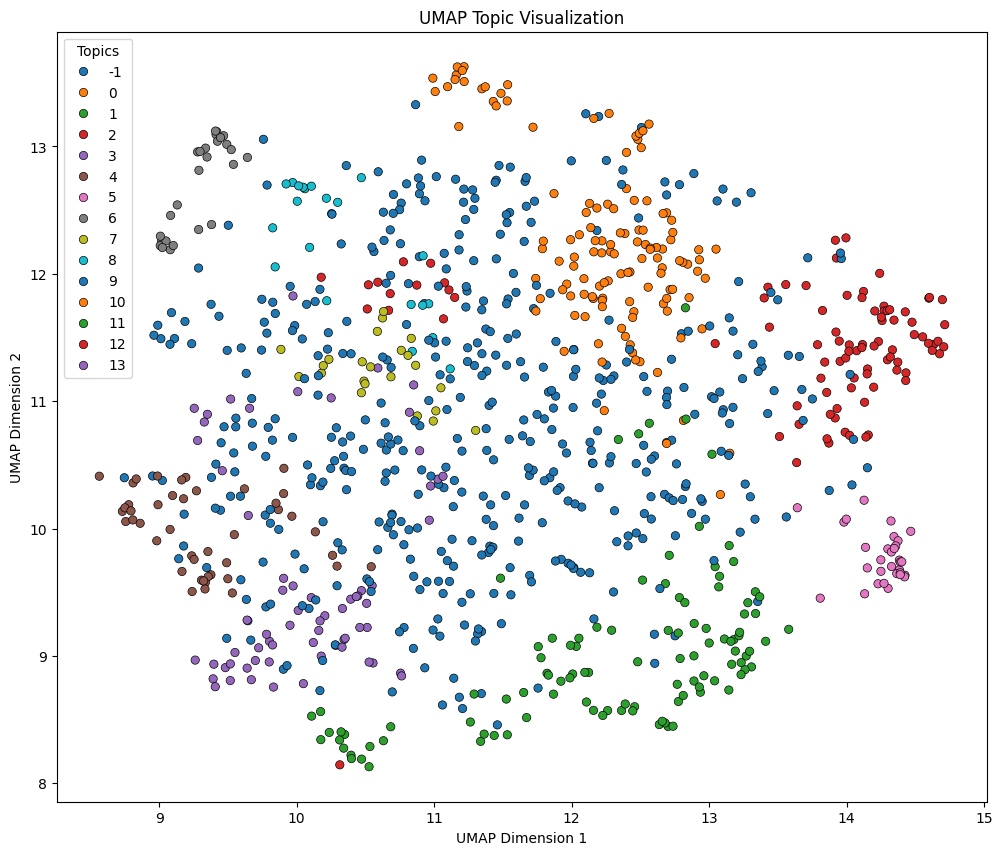

time: 49.2 s (started: 2024-07-21 17:17:03 +00:00)


In [33]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import umap

sampled_cleaned_text_list = sampled_cleaned_text.tolist()
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(sampled_cleaned_text_list)

# this model is used to convert text documents into numerical vectors! In essence is an embeddings technique.
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(sampled_cleaned_text_list, show_progress_bar=True)

# number of documents and embeddings ---checking
print(f"Number of documents: {len(docs)}")
print(f"Number of embeddings: {len(embeddings)}")

# using UMAP to perform dimensinality reduction
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings)

# Check topics to ensure it matches
print(f"topics assigned to documents: {topics}")

# here we extract the words for each topic
for topic_id in set(topics):
    if topic_id != -1:  # -1 signifies an outlier topic
        print(f"Topic {topic_id} with Keywords: {topic_model.get_topic(topic_id)}")

# here we extract thedocuments for each topic
my_represent_docs = topic_model.get_representative_docs()
for topic_id in set(topics):
    if topic_id != -1:  # Skip outlier topic
        print(f"Most common/important documents for topic {topic_id}:")
        for doc in my_represent_docs[topic_id]:
            print(doc)


umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP_Dime_1', 'UMAP_Dime_2'])
umap_df['topic'] = topics

# Plotting visualization, for the REDUCED 2D results
plt.figure(figsize=(12, 10))
sns.scatterplot(data=umap_df, x='UMAP_Dime_1', y='UMAP_Dime_2', hue='topic', palette='tab10', edgecolor='k')
plt.title("UMAP Topic Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Topics')
plt.show()

In [34]:
sampled_cleaned_text.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1000,)

time: 5.68 ms (started: 2024-07-21 17:17:52 +00:00)


------------------------------------------ **FINAL RESULTS COMPARISON** ------------------------------

All results for the **TOP-5** (based on the hyperparameter checked) case of each model
THe **BERTopic** seems to provide the highest coherence score

In [35]:
sorted_df_LADS = results_df.sort_values(by='coherence', ascending=False)
sorted_df_BERT = results_df_BERT.sort_values(by='coherence', ascending=False)
sorted_df_LSA = results_df_LSA.sort_values(by='coherence', ascending=False)
# Get the top 10 rows
top_ten_df_LADS = sorted_df_LADS.head(5)
top_ten_df_BERT = sorted_df_BERT.head(5)
top_ten_df_LSA = sorted_df_LSA.head(5)

final_results_BERT_LAD_LSA = pd.concat([top_ten_df_LADS, top_ten_df_BERT, top_ten_df_LSA], ignore_index=True, sort=False)

final_results_BERT_LAD_LSA = final_results_BERT_LAD.fillna("-")

final_results_BERT_LAD_LSA.sort_values(by='coherence', ascending=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics       alpha eta iterations gamma_threshold  coherence  \
10          -           -   -          -               -   0.831701   
11          -           -   -          -               -   0.809144   
12          -           -   -          -               -   0.748102   
13          -           -   -          -               -   0.715138   
14          -           -   -          -               -   0.670566   
1        10.0           1   1       50.0           0.001   0.644640   
0        10.0           1   1      100.0           0.001   0.644640   
3        10.0           1   1       50.0            0.01   0.641850   
2        10.0           1   1      100.0            0.01   0.641850   
15          -           -   -          -               -   0.622518   
16          -           -   -          -               -   0.558012   
17          -           -   -          -               -   0.504461   
4         5.0  asymmetric   1       50.0            0.01   0.502020   
18          -           -   -          -               -   0.496943   
19          -           -   -          -               -   0.491648   
5         5.0         0.1   1      100.0           0.001   0.491193   
6         5.0  asymmetric   1       50.0           0.001   0.482654   
7         5.0         0.1   1      100.0            0.01   0.470084   
8         5.0  asymmetric   1      100.0           0.001   0.468894   
9         5.0        0.01   1      100.0            0.01   0.467947   

   perplexity silhouette_score davies_bouldin_index  \
10          -                -                    -   
11          -                -                    -   
12          -                -                    -   
13          -                -                    -   
14          -                -                    -   
1   -8.316868         0.336871             0.584514   
0   -8.316868         0.336871             0.584514   
3   -8.316962         0.396844             0.619592   
2   -8.316962         0.396844             0.619592   
15          -                -                    -   
16          -                -                    -   
17          -                -                    -   
4    -7.83957         0.763992             0.317717   
18          -                -                    -   
19          -                -                    -   
5   -7.849722          0.78189             0.310819   
6   -7.839712         0.765512             0.325026   
7   -7.847911         0.803867               0.2986   
8   -7.839851         0.790618             0.295123   
9   -7.816204         0.841657              0.31311   

                                            lda_model nr_topics  \
10                                                  -      20.0   
11                                                  -      10.0   
12                                                  -      15.0   
13                                                  -      10.0   
14                                                  -      20.0   
1   LdaModel<num_terms=4309, num_topics=10, decay=...         -   
0   LdaModel<num_terms=4309, num_topics=10, decay=...         -   
3   LdaModel<num_terms=4309, num_topics=10, decay=...         -   
2   LdaModel<num_terms=4309, num_topics=10, decay=...         -   
15                                                  -      15.0   
16                                                  -      10.0   
17                                                  -      20.0   
4   LdaModel<num_terms=4309, num_topics=5, decay=0...         -   
18                                                  -      10.0   
19                                                  -      15.0   
5   LdaModel<num_terms=4309, num_topics=5, decay=0...         -   
6   LdaModel<num_terms=4309, num_topics=5, decay=0...         -   
7   LdaModel<num_terms=4309, num_topics=5, decay=0...         -   
8   LdaModel<num_terms=4309, num_topics=5, decay=0...         -   
9   LdaModel<nu

time: 87 ms (started: 2024-07-21 17:17:52 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Number of documents: 1000
Number of embeddings: 1000


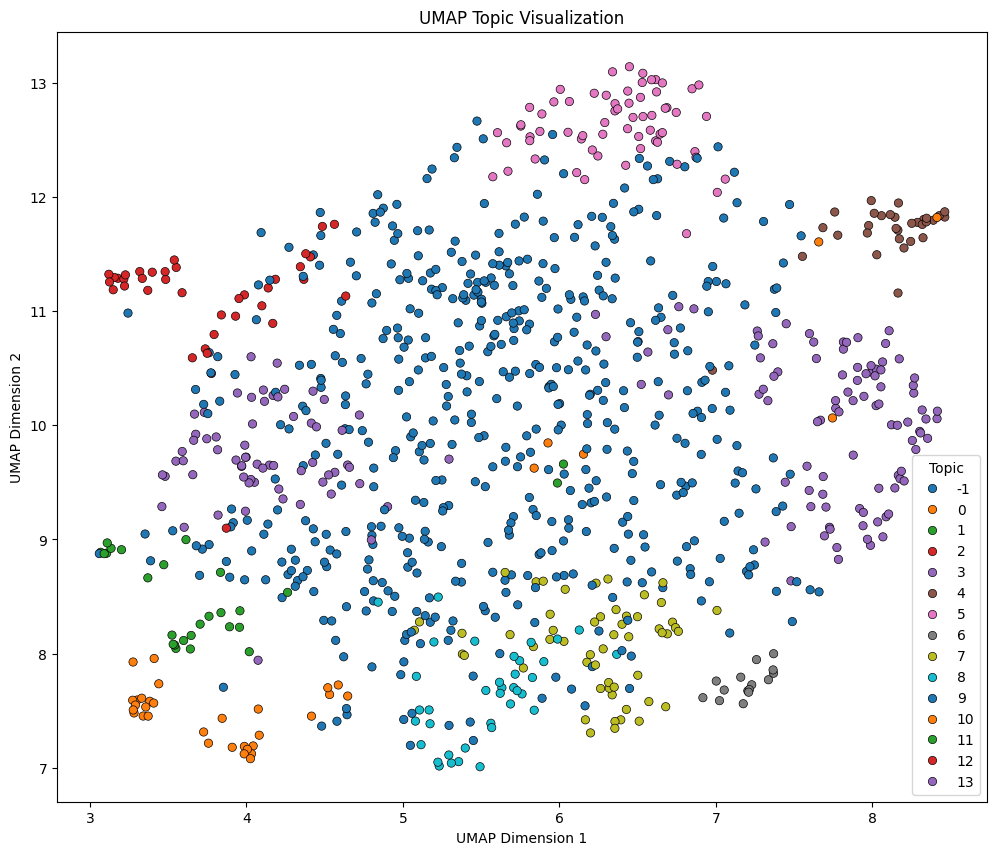

time: 47.3 s (started: 2024-07-21 17:17:52 +00:00)


In [36]:
# Applying dimensionality reduction to he best model parameters
best_model_params = results_df_BERT.sort_values(by='coherence', ascending=False).iloc[0]
best_nr_topics = int(best_model_params['nr_topics'])
best_min_topic_size = int(best_model_params['min_topic_size'])
best_top_n_words = int(best_model_params['top_n_words'])

# fitting the BERTopic  with the best parameters
best_topic_model = BERTopic(
    nr_topics=best_nr_topics,
    min_topic_size=best_min_topic_size,
    top_n_words=best_top_n_words
)
best_topic_model.fit(sampled_cleaned_text)

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

sampled_cleaned_text_list = sampled_cleaned_text.tolist()
embeddings = embedding_model.encode(sampled_cleaned_text_list, show_progress_bar=True)

# Number of documents and embeddings -- Checking
print(f"Number of documents: {len(sampled_cleaned_text_list)}")
print(f"Number of embeddings: {len(embeddings)}")

#  UMAP dimensionality reduction
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings)

#  topics for each document
topics = best_topic_model.get_document_info(sampled_cleaned_text)['Topic']


umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP_Dim_1', 'UMAP_Dim_2'])
umap_df['Topic'] = topics

# Plotting visualization for the reduced 2D results
plt.figure(figsize=(12, 10))
sns.scatterplot(data=umap_df, x='UMAP_Dim_1', y='UMAP_Dim_2', hue='Topic', palette='tab10', edgecolor='k')
plt.title("UMAP Topic Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Topic')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


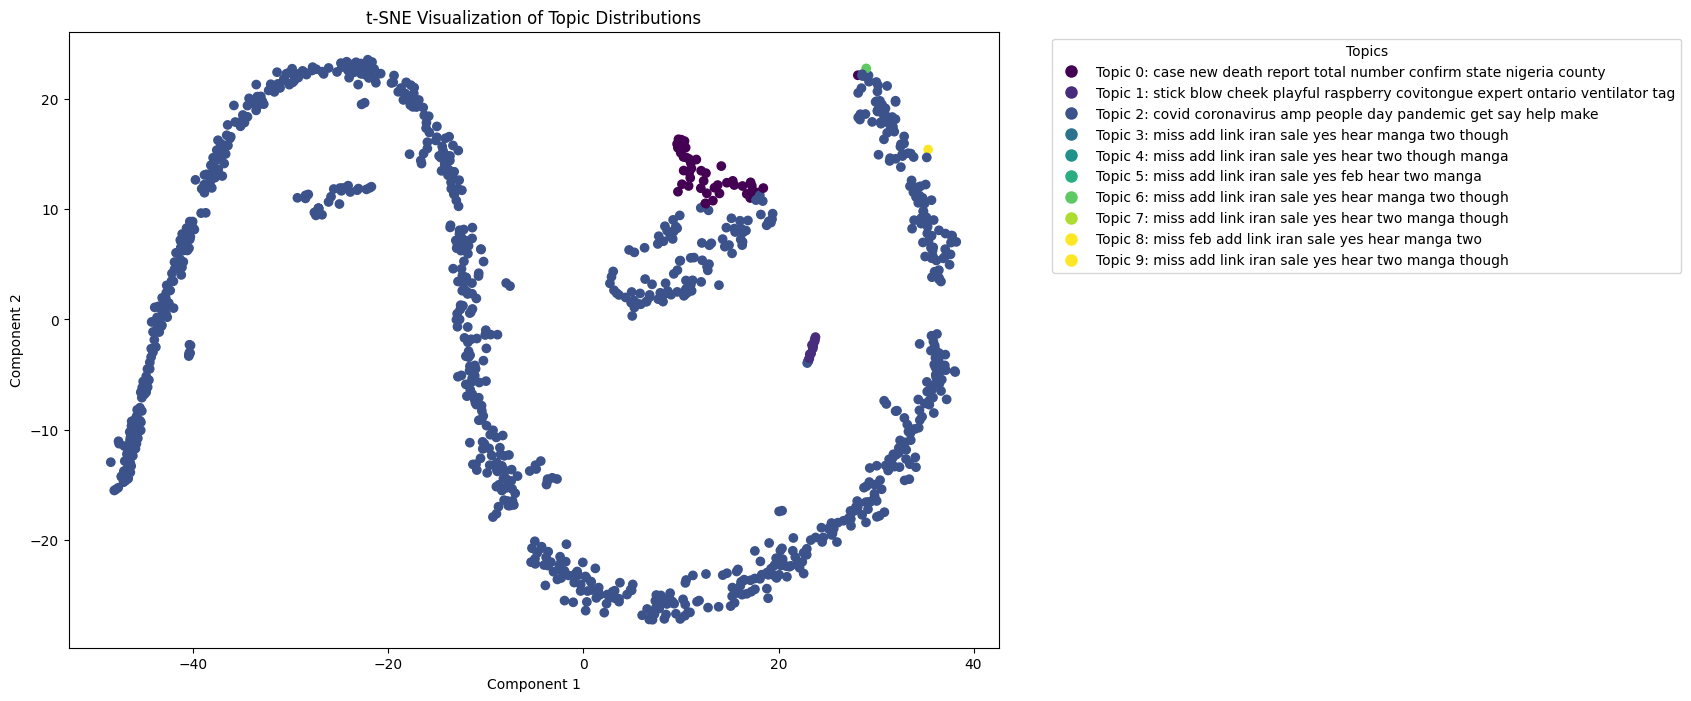

time: 15.8 s (started: 2024-07-21 17:18:40 +00:00)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import gensim
from gensim.corpora import Dictionary

# Lusing parameters of best LDA evaluateed model, based on coherence score
best_lda_params = results_df.loc[results_df['coherence'].idxmax()]
num_topics = int(best_lda_params['num_topics'])
alpha = best_lda_params['alpha']
eta = best_lda_params['eta']
iterations = int(best_lda_params['iterations'])
gamma_threshold = best_lda_params['gamma_threshold']

# re-creating the best LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha=alpha,
    eta=eta,
    iterations=iterations,
    eval_every=1,
    minimum_probability=0.01,
    gamma_threshold=gamma_threshold
)

# document-topic matrix
doc_topic_matrix = np.zeros((len(corpus), lda_model.num_topics))

for i, doc in enumerate(corpus):
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
    for topic_id, prob in topic_probs:
        doc_topic_matrix[i, topic_id] = prob

# applying the t-SNE
tsne_model = TSNE(n_components=2, random_state=0)
topic_embeddings = tsne_model.fit_transform(doc_topic_matrix)

# top words for each topic
topic_names = {}
for topic_id in range(lda_model.num_topics):
    top_words = [word for word, _ in lda_model.show_topic(topic_id, 10)]
    topic_names[topic_id] = ' '.join(top_words)

# main topic for each document
doc_topic_labels = np.argmax(doc_topic_matrix, axis=1)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(topic_embeddings[:, 0], topic_embeddings[:, 1], c=doc_topic_labels, cmap='viridis', marker='o')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(idx)), markersize=10, label=f'Topic {idx}: {topic_names[idx]}') for idx in range(lda_model.num_topics)]
plt.legend(handles=handles, title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE Visualization of Topic Distributions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

time: 15.8 s (started: 2024-07-21 17:18:40 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 15.8 s (started: 2024-07-21 17:18:40 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
